# EuroSAT Dataset Applying Pre-trained CNN AlexNet

In [18]:
import os
import pandas as pd
import numpy as np
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
import platform
import psutil
import random
import cv2
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

from PIL import Image
from PIL import ImageOps

import torch
import torch.nn.functional as F
import torch.optim as optim

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR

import torchvision
import torchvision.models as models

from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur

from tqdm.notebook import tqdm
from tqdm import tqdm

from torchinfo import summary
from torchsummary import summary

from collections import OrderedDict

from tabulate import tabulate

### Configuration

In [19]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


### Seed Value

In [20]:
seed = 5
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Loading Dataset

In [21]:
data_dir = "/kaggle/input/eurosat-dataset/EuroSAT"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
     if not class_name.lower().endswith(('.csv', '.json')):
        class_dir = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, image_name))
            labels.append(class_name)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1).reset_index(drop=True)

### Class Count & Bar Plot

class: HerbaceousVegetation --> count: 3000
class: AnnualCrop --> count: 3000
class: Forest --> count: 3000
class: SeaLake --> count: 3000
class: Residential --> count: 3000
class: PermanentCrop --> count: 2500
class: Industrial --> count: 2500
class: River --> count: 2500
class: Highway --> count: 2500
class: Pasture --> count: 2000


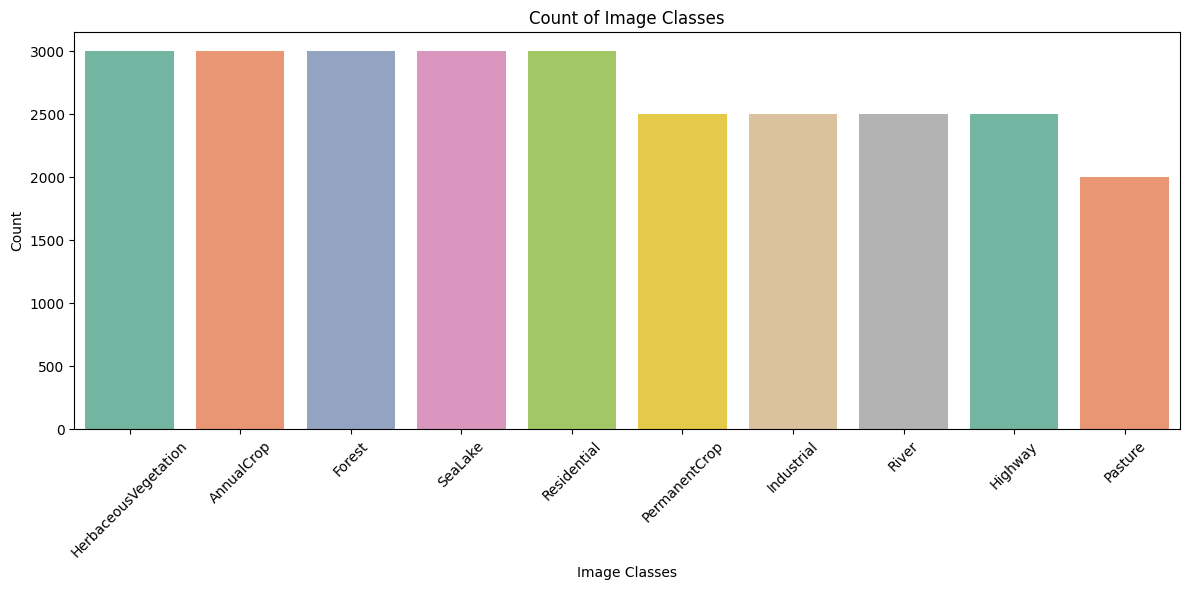

In [22]:
# Class count and Bar plot
class_count = df['label'].value_counts()

for class_name , count in class_count.items():
    print(f"class: {class_name} --> count: {count}")

# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index, palette='Set2')
plt.title('Count of Image Classes')
plt.xlabel('Image Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Sample Images From Each Classes

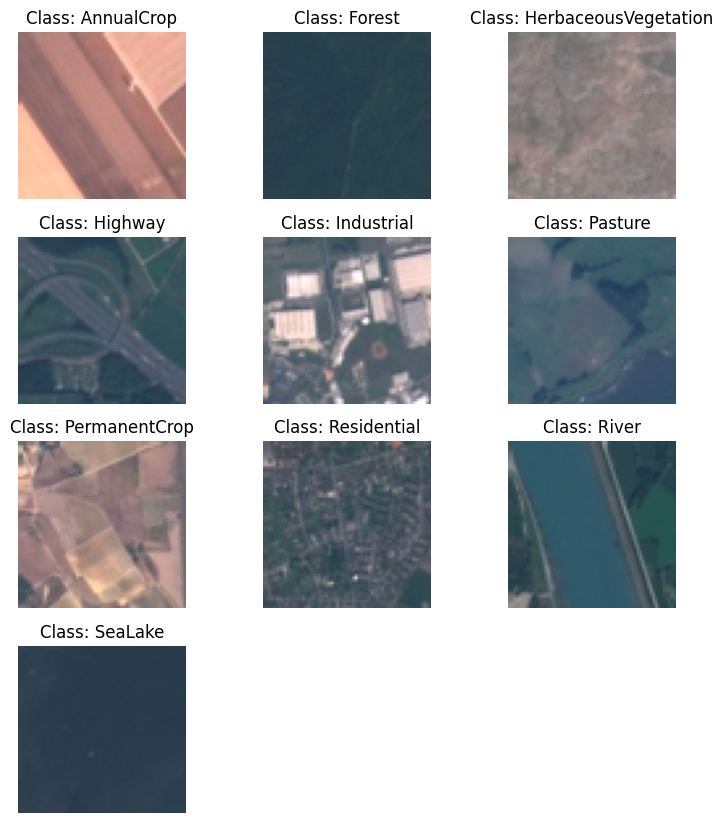

In [23]:
# Get class names
class_names = sorted(df['label'].unique())

# set up figure
plt.figure(figsize=(3 * 2.5, len(class_names) / 3  * 2.5))

# One sample image per class
for i, class_name in enumerate(class_names):
    try:
        # get sample for this class
        path = df[df['label'] == class_name]['file_path'].sample(1).values[0]
        with Image.open(path) as img:
            plt.subplot(int(len(class_names) / 3)+1, 3, i+1)
            plt.imshow(img)
            plt.title(f"Class: {class_name}")
            plt.axis('off')
    except Exception as e:
        print(f"Error reading image {path}: {e}")
        continue


plt.tight_layout()
plt.show()

### Train-Test-Validation Split (Ratio 70:15:15)

In [24]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30,
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50,
                                            stratify=temp_dataframe['label'], random_state=42)

In [25]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  18900
Validation Data:  4050
Test Data:  4050
-------------------------------------------
Total amounts of data in the dataset:  27000


In [26]:

class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_df['label'].value_counts()

train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Train Dataset
Class                   Count
--------------------  -------
Residential              2100
SeaLake                  2100
AnnualCrop               2100
Forest                   2100
HerbaceousVegetation     2100
PermanentCrop            1750
Industrial               1750
Highway                  1750
River                    1750
Pasture                  1400

Validation Dataset
Class                   Count
--------------------  -------
AnnualCrop                450
SeaLake                   450
Residential               450
HerbaceousVegetation      450
Forest                    450
Highway                   375
Industrial                375
PermanentCrop             375
River                     375
Pasture                   300

Test Dataset
Class                   Count
--------------------  -------
SeaLake                   450
AnnualCrop                450
Forest                    450
HerbaceousVegetation      450
Residential               450
PermanentCrop         

Label mapping

In [27]:
classes = sorted(df['label'].unique())
label_map = {class_name: i for i, class_name in enumerate(classes)}
print(label_map)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


### Device Variable

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Checkpoint

In [29]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

### Integrate Class-weight Loss

In [30]:
# Extract class labels from your training dataframe
train_labels = train_dataframe['label'].map(label_map).values
num_classes = len(classes)

# print(np.unique(train_labels))
# print(np.arange(num_classes))

# Compute weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(num_classes), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

### Dataset Class, Dataloader and Transform

In [31]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.label_map = label_map

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [32]:
train_batch = 64 
val_batch = 8

def data_transfrom():
    size = 224
    normalize = transforms.Compose([
            transforms.Resize((size,size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()
    ])
    
    train_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.ToTensor(),
    ])

    train_dataset = ImageDataset (
        train_dataframe,
        train_transform,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_df,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=2)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=2)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=2)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

### Neural Network (AlexNet)

In [39]:
total_class = 10
learning_rate = 0.0001

model = models.alexnet(pretrained=False)

in_features = model.classifier[6].in_features 
model.classifier[6] = nn.Linear(in_features, total_class)

model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

### Training

In [40]:
start_time = time.time()

def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=150, early_stop_patience=150, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print('Training Loss: {:.3f} Acc: {:.3f}'.format(epoch_train_loss, epoch_train_acc))

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print('Validation Loss: {:.3f} Acc: {:.3f}'.format(epoch_val_loss, epoch_val_acc))

        # Check for early stopping
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"✅ Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
        else:
            num_epochs_loss_greater = 0

        if consecutive_no_improvement >= early_stop_patience or num_epochs_loss_greater >= early_stop_patience:
            print(f"⏹️ Early stopping criteria met. No improvement in validation accuracy or validation loss for {early_stop_patience} consecutive epochs. Training stopped.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(
    model,
    criterion,
    optimizer,
    dataloader_train_dataset,
    dataloader_valid_dataset,
    save_path_checkpoints=save_path_checkpoints
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('/kaggle/working/training_data.xlsx', index=False)

Epoch 1/150: 100%|██████████| 296/296 [01:23<00:00,  3.56it/s, acc=0.339, loss=1.63]

Training Loss: 1.634 Acc: 0.339


Validation Loss: 1.344 Acc: 0.474
✅ Best model saved at epoch 1 with validation accuracy: 0.474


Epoch 2/150: 100%|██████████| 296/296 [00:51<00:00,  5.70it/s, acc=0.585, loss=1.12]

Training Loss: 1.123 Acc: 0.585


Validation Loss: 1.038 Acc: 0.633
✅ Best model saved at epoch 2 with validation accuracy: 0.633


Epoch 3/150: 100%|██████████| 296/296 [00:51<00:00,  5.71it/s, acc=0.667, loss=0.94] 

Training Loss: 0.940 Acc: 0.667


Validation Loss: 0.978 Acc: 0.633
✅ Best model saved at epoch 3 with validation accuracy: 0.633


Epoch 4/150: 100%|██████████| 296/296 [00:51<00:00,  5.70it/s, acc=0.692, loss=0.859]

Training Loss: 0.859 Acc: 0.692


Validation Loss: 0.785 Acc: 0.719
✅ Best model saved at epoch 4 with validation accuracy: 0.719


Epoch 5/150: 100%|██████████| 296/296 [00:52<00:00,  5.61it/s, acc=0.719, loss=0.794]

Training Loss: 0.794 Acc: 0.719


Validation Loss: 0.765 Acc: 0.737
✅ Best model saved at epoch 5 with validation accuracy: 0.737


Epoch 6/150: 100%|██████████| 296/296 [00:51<00:00,  5.71it/s, acc=0.733, loss=0.752]

Training Loss: 0.752 Acc: 0.733


Validation Loss: 0.585 Acc: 0.791
✅ Best model saved at epoch 6 with validation accuracy: 0.791


Epoch 7/150: 100%|██████████| 296/296 [00:52<00:00,  5.69it/s, acc=0.753, loss=0.702]

Training Loss: 0.702 Acc: 0.753


Validation Loss: 0.536 Acc: 0.811
✅ Best model saved at epoch 7 with validation accuracy: 0.811


Epoch 8/150: 100%|██████████| 296/296 [00:51<00:00,  5.78it/s, acc=0.771, loss=0.663]

Training Loss: 0.663 Acc: 0.771


Validation Loss: 0.529 Acc: 0.819
✅ Best model saved at epoch 8 with validation accuracy: 0.819


Epoch 9/150: 100%|██████████| 296/296 [00:51<00:00,  5.75it/s, acc=0.789, loss=0.608]

Training Loss: 0.608 Acc: 0.789


Validation Loss: 0.577 Acc: 0.792


Epoch 10/150: 100%|██████████| 296/296 [00:51<00:00,  5.70it/s, acc=0.802, loss=0.577]

Training Loss: 0.577 Acc: 0.802


Validation Loss: 0.601 Acc: 0.794


Epoch 11/150: 100%|██████████| 296/296 [00:51<00:00,  5.78it/s, acc=0.816, loss=0.534]

Training Loss: 0.534 Acc: 0.816


Validation Loss: 0.795 Acc: 0.737


Epoch 12/150: 100%|██████████| 296/296 [00:51<00:00,  5.78it/s, acc=0.826, loss=0.509]

Training Loss: 0.509 Acc: 0.826


Validation Loss: 0.419 Acc: 0.856
✅ Best model saved at epoch 12 with validation accuracy: 0.856


Epoch 13/150: 100%|██████████| 296/296 [00:53<00:00,  5.57it/s, acc=0.842, loss=0.458]

Training Loss: 0.458 Acc: 0.842


Validation Loss: 0.408 Acc: 0.853


Epoch 14/150: 100%|██████████| 296/296 [00:51<00:00,  5.76it/s, acc=0.845, loss=0.452]

Training Loss: 0.452 Acc: 0.845


Validation Loss: 0.431 Acc: 0.853


Epoch 15/150: 100%|██████████| 296/296 [00:51<00:00,  5.80it/s, acc=0.856, loss=0.412]

Training Loss: 0.412 Acc: 0.856


Validation Loss: 0.337 Acc: 0.881
✅ Best model saved at epoch 15 with validation accuracy: 0.881


Epoch 16/150: 100%|██████████| 296/296 [00:51<00:00,  5.73it/s, acc=0.864, loss=0.392]

Training Loss: 0.392 Acc: 0.864


Validation Loss: 0.356 Acc: 0.868


Epoch 17/150: 100%|██████████| 296/296 [00:51<00:00,  5.80it/s, acc=0.868, loss=0.382]

Training Loss: 0.382 Acc: 0.868


Validation Loss: 0.389 Acc: 0.861


Epoch 18/150: 100%|██████████| 296/296 [00:51<00:00,  5.76it/s, acc=0.879, loss=0.355]

Training Loss: 0.355 Acc: 0.879


Validation Loss: 0.375 Acc: 0.878


Epoch 19/150: 100%|██████████| 296/296 [00:52<00:00,  5.62it/s, acc=0.88, loss=0.348] 

Training Loss: 0.348 Acc: 0.880


Validation Loss: 0.413 Acc: 0.850


Epoch 20/150: 100%|██████████| 296/296 [00:51<00:00,  5.78it/s, acc=0.888, loss=0.328]

Training Loss: 0.328 Acc: 0.888


Validation Loss: 0.264 Acc: 0.915
✅ Best model saved at epoch 20 with validation accuracy: 0.915


Epoch 21/150: 100%|██████████| 296/296 [00:51<00:00,  5.76it/s, acc=0.893, loss=0.309]

Training Loss: 0.309 Acc: 0.893


Validation Loss: 0.293 Acc: 0.892


Epoch 22/150: 100%|██████████| 296/296 [00:51<00:00,  5.80it/s, acc=0.902, loss=0.29] 

Training Loss: 0.290 Acc: 0.902


Validation Loss: 0.343 Acc: 0.879


Epoch 23/150: 100%|██████████| 296/296 [00:52<00:00,  5.67it/s, acc=0.898, loss=0.299]

Training Loss: 0.299 Acc: 0.898


Validation Loss: 0.266 Acc: 0.906


Epoch 24/150: 100%|██████████| 296/296 [00:51<00:00,  5.70it/s, acc=0.901, loss=0.285]

Training Loss: 0.285 Acc: 0.901


Validation Loss: 0.265 Acc: 0.912


Epoch 25/150: 100%|██████████| 296/296 [00:51<00:00,  5.79it/s, acc=0.906, loss=0.27] 

Training Loss: 0.270 Acc: 0.906


Validation Loss: 0.226 Acc: 0.918
✅ Best model saved at epoch 25 with validation accuracy: 0.918


Epoch 26/150: 100%|██████████| 296/296 [00:50<00:00,  5.84it/s, acc=0.913, loss=0.253]

Training Loss: 0.253 Acc: 0.913


Validation Loss: 0.306 Acc: 0.892


Epoch 27/150: 100%|██████████| 296/296 [00:51<00:00,  5.78it/s, acc=0.912, loss=0.252]

Training Loss: 0.252 Acc: 0.912


Validation Loss: 0.314 Acc: 0.898


Epoch 28/150: 100%|██████████| 296/296 [00:51<00:00,  5.77it/s, acc=0.913, loss=0.256]

Training Loss: 0.256 Acc: 0.913


Validation Loss: 0.247 Acc: 0.916


Epoch 29/150: 100%|██████████| 296/296 [00:51<00:00,  5.74it/s, acc=0.919, loss=0.238]

Training Loss: 0.238 Acc: 0.919


Validation Loss: 0.218 Acc: 0.925
✅ Best model saved at epoch 29 with validation accuracy: 0.925


Epoch 30/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.916, loss=0.239]

Training Loss: 0.239 Acc: 0.916


Validation Loss: 0.315 Acc: 0.891


Epoch 31/150: 100%|██████████| 296/296 [00:51<00:00,  5.73it/s, acc=0.922, loss=0.224]

Training Loss: 0.224 Acc: 0.922


Validation Loss: 0.183 Acc: 0.939
✅ Best model saved at epoch 31 with validation accuracy: 0.939


Epoch 32/150: 100%|██████████| 296/296 [00:52<00:00,  5.66it/s, acc=0.924, loss=0.218]

Training Loss: 0.218 Acc: 0.924


Validation Loss: 0.213 Acc: 0.928


Epoch 33/150: 100%|██████████| 296/296 [00:51<00:00,  5.77it/s, acc=0.928, loss=0.206]

Training Loss: 0.206 Acc: 0.928


Validation Loss: 0.264 Acc: 0.904


Epoch 34/150: 100%|██████████| 296/296 [00:52<00:00,  5.69it/s, acc=0.925, loss=0.211]

Training Loss: 0.211 Acc: 0.925


Validation Loss: 0.293 Acc: 0.906


Epoch 35/150: 100%|██████████| 296/296 [00:51<00:00,  5.75it/s, acc=0.927, loss=0.204]

Training Loss: 0.204 Acc: 0.927


Validation Loss: 0.204 Acc: 0.935


Epoch 36/150: 100%|██████████| 296/296 [00:51<00:00,  5.73it/s, acc=0.929, loss=0.204]

Training Loss: 0.204 Acc: 0.929


Validation Loss: 0.216 Acc: 0.929


Epoch 37/150: 100%|██████████| 296/296 [00:51<00:00,  5.73it/s, acc=0.928, loss=0.199]

Training Loss: 0.199 Acc: 0.928


Validation Loss: 0.202 Acc: 0.934


Epoch 38/150: 100%|██████████| 296/296 [00:51<00:00,  5.72it/s, acc=0.936, loss=0.182]

Training Loss: 0.182 Acc: 0.936


Validation Loss: 0.226 Acc: 0.924


Epoch 39/150: 100%|██████████| 296/296 [00:51<00:00,  5.70it/s, acc=0.936, loss=0.186]

Training Loss: 0.186 Acc: 0.936


Validation Loss: 0.232 Acc: 0.917


Epoch 40/150: 100%|██████████| 296/296 [00:51<00:00,  5.75it/s, acc=0.938, loss=0.175]

Training Loss: 0.175 Acc: 0.938


Validation Loss: 0.228 Acc: 0.926


Epoch 41/150: 100%|██████████| 296/296 [00:51<00:00,  5.77it/s, acc=0.938, loss=0.173]

Training Loss: 0.173 Acc: 0.938


Validation Loss: 0.222 Acc: 0.926


Epoch 42/150: 100%|██████████| 296/296 [00:51<00:00,  5.78it/s, acc=0.935, loss=0.181]

Training Loss: 0.181 Acc: 0.935


Validation Loss: 0.242 Acc: 0.920


Epoch 43/150: 100%|██████████| 296/296 [00:52<00:00,  5.67it/s, acc=0.94, loss=0.169] 

Training Loss: 0.169 Acc: 0.940


Validation Loss: 0.329 Acc: 0.889


Epoch 44/150: 100%|██████████| 296/296 [00:51<00:00,  5.71it/s, acc=0.942, loss=0.16] 

Training Loss: 0.160 Acc: 0.942


Validation Loss: 0.212 Acc: 0.930


Epoch 45/150: 100%|██████████| 296/296 [00:51<00:00,  5.72it/s, acc=0.943, loss=0.162]

Training Loss: 0.162 Acc: 0.943


Validation Loss: 0.191 Acc: 0.935


Epoch 46/150: 100%|██████████| 296/296 [00:52<00:00,  5.66it/s, acc=0.943, loss=0.159]

Training Loss: 0.159 Acc: 0.943


Validation Loss: 0.218 Acc: 0.931


Epoch 47/150: 100%|██████████| 296/296 [00:51<00:00,  5.75it/s, acc=0.946, loss=0.152]

Training Loss: 0.152 Acc: 0.946


Validation Loss: 0.183 Acc: 0.940
✅ Best model saved at epoch 47 with validation accuracy: 0.940


Epoch 48/150: 100%|██████████| 296/296 [00:51<00:00,  5.70it/s, acc=0.949, loss=0.146]

Training Loss: 0.146 Acc: 0.949


Validation Loss: 0.194 Acc: 0.938


Epoch 49/150: 100%|██████████| 296/296 [00:52<00:00,  5.68it/s, acc=0.945, loss=0.154]

Training Loss: 0.154 Acc: 0.945


Validation Loss: 0.188 Acc: 0.936


Epoch 50/150: 100%|██████████| 296/296 [00:51<00:00,  5.72it/s, acc=0.945, loss=0.151]

Training Loss: 0.151 Acc: 0.945


Validation Loss: 0.345 Acc: 0.891


Epoch 51/150: 100%|██████████| 296/296 [00:51<00:00,  5.73it/s, acc=0.947, loss=0.15] 

Training Loss: 0.150 Acc: 0.947


Validation Loss: 0.230 Acc: 0.931


Epoch 52/150: 100%|██████████| 296/296 [00:52<00:00,  5.65it/s, acc=0.948, loss=0.147]

Training Loss: 0.147 Acc: 0.948


Validation Loss: 0.250 Acc: 0.920


Epoch 53/150: 100%|██████████| 296/296 [00:51<00:00,  5.71it/s, acc=0.953, loss=0.136]

Training Loss: 0.136 Acc: 0.953


Validation Loss: 0.205 Acc: 0.941
✅ Best model saved at epoch 53 with validation accuracy: 0.941


Epoch 54/150: 100%|██████████| 296/296 [00:51<00:00,  5.75it/s, acc=0.953, loss=0.129]

Training Loss: 0.129 Acc: 0.953


Validation Loss: 0.235 Acc: 0.931


Epoch 55/150: 100%|██████████| 296/296 [00:52<00:00,  5.68it/s, acc=0.953, loss=0.133]

Training Loss: 0.133 Acc: 0.953


Validation Loss: 0.165 Acc: 0.951
✅ Best model saved at epoch 55 with validation accuracy: 0.951


Epoch 56/150: 100%|██████████| 296/296 [00:52<00:00,  5.61it/s, acc=0.953, loss=0.133]

Training Loss: 0.133 Acc: 0.953


Validation Loss: 0.224 Acc: 0.926


Epoch 57/150: 100%|██████████| 296/296 [00:52<00:00,  5.67it/s, acc=0.955, loss=0.126]

Training Loss: 0.126 Acc: 0.955


Validation Loss: 0.191 Acc: 0.940


Epoch 58/150: 100%|██████████| 296/296 [00:51<00:00,  5.71it/s, acc=0.956, loss=0.125]

Training Loss: 0.125 Acc: 0.956


Validation Loss: 0.176 Acc: 0.946


Epoch 59/150: 100%|██████████| 296/296 [00:51<00:00,  5.70it/s, acc=0.953, loss=0.128]

Training Loss: 0.128 Acc: 0.953


Validation Loss: 0.192 Acc: 0.947


Epoch 60/150: 100%|██████████| 296/296 [00:52<00:00,  5.69it/s, acc=0.957, loss=0.121]

Training Loss: 0.121 Acc: 0.957


Validation Loss: 0.227 Acc: 0.928


Epoch 61/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.955, loss=0.125]

Training Loss: 0.125 Acc: 0.955


Validation Loss: 0.206 Acc: 0.940


Epoch 62/150: 100%|██████████| 296/296 [00:52<00:00,  5.65it/s, acc=0.961, loss=0.108] 

Training Loss: 0.108 Acc: 0.961


Validation Loss: 0.196 Acc: 0.940


Epoch 63/150: 100%|██████████| 296/296 [00:52<00:00,  5.65it/s, acc=0.96, loss=0.113] 

Training Loss: 0.113 Acc: 0.960


Validation Loss: 0.180 Acc: 0.943


Epoch 64/150: 100%|██████████| 296/296 [00:52<00:00,  5.65it/s, acc=0.961, loss=0.106] 

Training Loss: 0.106 Acc: 0.961


Validation Loss: 0.173 Acc: 0.951


Epoch 65/150: 100%|██████████| 296/296 [00:52<00:00,  5.68it/s, acc=0.96, loss=0.112]  

Training Loss: 0.112 Acc: 0.960


Validation Loss: 0.172 Acc: 0.948


Epoch 66/150: 100%|██████████| 296/296 [00:52<00:00,  5.64it/s, acc=0.961, loss=0.108] 

Training Loss: 0.108 Acc: 0.961


Validation Loss: 0.280 Acc: 0.921


Epoch 67/150: 100%|██████████| 296/296 [00:52<00:00,  5.62it/s, acc=0.964, loss=0.105] 

Training Loss: 0.105 Acc: 0.964


Validation Loss: 0.181 Acc: 0.945


Epoch 68/150: 100%|██████████| 296/296 [00:51<00:00,  5.70it/s, acc=0.965, loss=0.0997]

Training Loss: 0.100 Acc: 0.965


Validation Loss: 0.192 Acc: 0.946


Epoch 69/150: 100%|██████████| 296/296 [00:52<00:00,  5.64it/s, acc=0.965, loss=0.0975]

Training Loss: 0.097 Acc: 0.965


Validation Loss: 0.232 Acc: 0.934


Epoch 70/150: 100%|██████████| 296/296 [00:53<00:00,  5.58it/s, acc=0.963, loss=0.105]

Training Loss: 0.105 Acc: 0.963


Validation Loss: 0.188 Acc: 0.946


Epoch 71/150: 100%|██████████| 296/296 [00:51<00:00,  5.70it/s, acc=0.966, loss=0.0961]

Training Loss: 0.096 Acc: 0.966


Validation Loss: 0.239 Acc: 0.943


Epoch 72/150: 100%|██████████| 296/296 [00:53<00:00,  5.55it/s, acc=0.963, loss=0.104] 

Training Loss: 0.104 Acc: 0.963


Validation Loss: 0.170 Acc: 0.948


Epoch 73/150: 100%|██████████| 296/296 [00:52<00:00,  5.61it/s, acc=0.966, loss=0.0963]

Training Loss: 0.096 Acc: 0.966


Validation Loss: 0.176 Acc: 0.950


Epoch 74/150: 100%|██████████| 296/296 [00:52<00:00,  5.66it/s, acc=0.967, loss=0.0952]

Training Loss: 0.095 Acc: 0.967


Validation Loss: 0.228 Acc: 0.934


Epoch 75/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.965, loss=0.0979]

Training Loss: 0.098 Acc: 0.965


Validation Loss: 0.174 Acc: 0.951


Epoch 76/150: 100%|██████████| 296/296 [00:51<00:00,  5.71it/s, acc=0.968, loss=0.0934]

Training Loss: 0.093 Acc: 0.968


Validation Loss: 0.189 Acc: 0.945


Epoch 77/150: 100%|██████████| 296/296 [00:52<00:00,  5.65it/s, acc=0.969, loss=0.091] 

Training Loss: 0.091 Acc: 0.969


Validation Loss: 0.176 Acc: 0.951
✅ Best model saved at epoch 77 with validation accuracy: 0.951


Epoch 78/150: 100%|██████████| 296/296 [00:51<00:00,  5.71it/s, acc=0.967, loss=0.0926]

Training Loss: 0.093 Acc: 0.967


Validation Loss: 0.223 Acc: 0.937


Epoch 79/150: 100%|██████████| 296/296 [00:51<00:00,  5.71it/s, acc=0.97, loss=0.0835] 

Training Loss: 0.084 Acc: 0.970


Validation Loss: 0.249 Acc: 0.931


Epoch 80/150: 100%|██████████| 296/296 [00:51<00:00,  5.72it/s, acc=0.97, loss=0.087]  

Training Loss: 0.087 Acc: 0.970


Validation Loss: 0.165 Acc: 0.955
✅ Best model saved at epoch 80 with validation accuracy: 0.955


Epoch 81/150: 100%|██████████| 296/296 [00:51<00:00,  5.70it/s, acc=0.967, loss=0.0939]

Training Loss: 0.094 Acc: 0.967


Validation Loss: 0.190 Acc: 0.950


Epoch 82/150: 100%|██████████| 296/296 [00:52<00:00,  5.66it/s, acc=0.966, loss=0.0935]

Training Loss: 0.093 Acc: 0.966


Validation Loss: 0.201 Acc: 0.941


Epoch 83/150: 100%|██████████| 296/296 [00:52<00:00,  5.67it/s, acc=0.974, loss=0.0737]

Training Loss: 0.074 Acc: 0.974


Validation Loss: 0.236 Acc: 0.940


Epoch 84/150: 100%|██████████| 296/296 [00:51<00:00,  5.71it/s, acc=0.968, loss=0.0936]

Training Loss: 0.094 Acc: 0.968


Validation Loss: 0.225 Acc: 0.944


Epoch 85/150: 100%|██████████| 296/296 [00:51<00:00,  5.74it/s, acc=0.97, loss=0.0857] 

Training Loss: 0.086 Acc: 0.970


Validation Loss: 0.207 Acc: 0.944


Epoch 86/150: 100%|██████████| 296/296 [00:51<00:00,  5.79it/s, acc=0.972, loss=0.0783]

Training Loss: 0.078 Acc: 0.972


Validation Loss: 0.268 Acc: 0.934


Epoch 87/150: 100%|██████████| 296/296 [00:51<00:00,  5.73it/s, acc=0.97, loss=0.083]  

Training Loss: 0.083 Acc: 0.970


Validation Loss: 0.200 Acc: 0.948


Epoch 88/150: 100%|██████████| 296/296 [00:51<00:00,  5.74it/s, acc=0.972, loss=0.0825]

Training Loss: 0.083 Acc: 0.972


Validation Loss: 0.203 Acc: 0.944


Epoch 89/150: 100%|██████████| 296/296 [00:52<00:00,  5.69it/s, acc=0.972, loss=0.0765]

Training Loss: 0.077 Acc: 0.972


Validation Loss: 0.216 Acc: 0.947


Epoch 90/150: 100%|██████████| 296/296 [00:52<00:00,  5.67it/s, acc=0.97, loss=0.0849] 

Training Loss: 0.085 Acc: 0.970


Validation Loss: 0.205 Acc: 0.942


Epoch 91/150: 100%|██████████| 296/296 [00:51<00:00,  5.72it/s, acc=0.974, loss=0.0728]

Training Loss: 0.073 Acc: 0.974


Validation Loss: 0.190 Acc: 0.952


Epoch 92/150: 100%|██████████| 296/296 [00:52<00:00,  5.65it/s, acc=0.975, loss=0.0685]

Training Loss: 0.068 Acc: 0.975


Validation Loss: 0.224 Acc: 0.946


Epoch 93/150: 100%|██████████| 296/296 [00:52<00:00,  5.64it/s, acc=0.973, loss=0.0744]

Training Loss: 0.074 Acc: 0.973


Validation Loss: 0.276 Acc: 0.928


Epoch 94/150: 100%|██████████| 296/296 [00:52<00:00,  5.68it/s, acc=0.973, loss=0.0784]

Training Loss: 0.078 Acc: 0.973


Validation Loss: 0.229 Acc: 0.940


Epoch 95/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.973, loss=0.0732]

Training Loss: 0.073 Acc: 0.973


Validation Loss: 0.233 Acc: 0.941


Epoch 96/150: 100%|██████████| 296/296 [00:52<00:00,  5.61it/s, acc=0.975, loss=0.0693]

Training Loss: 0.069 Acc: 0.975


Validation Loss: 0.269 Acc: 0.937


Epoch 97/150: 100%|██████████| 296/296 [00:52<00:00,  5.65it/s, acc=0.975, loss=0.075] 

Training Loss: 0.075 Acc: 0.975


Validation Loss: 0.196 Acc: 0.946


Epoch 98/150: 100%|██████████| 296/296 [00:51<00:00,  5.70it/s, acc=0.976, loss=0.0672]

Training Loss: 0.067 Acc: 0.976


Validation Loss: 0.245 Acc: 0.935


Epoch 99/150: 100%|██████████| 296/296 [00:51<00:00,  5.70it/s, acc=0.977, loss=0.0656]

Training Loss: 0.066 Acc: 0.977


Validation Loss: 0.325 Acc: 0.913


Epoch 100/150: 100%|██████████| 296/296 [00:52<00:00,  5.68it/s, acc=0.975, loss=0.0724]

Training Loss: 0.072 Acc: 0.975


Validation Loss: 0.194 Acc: 0.952


Epoch 101/150: 100%|██████████| 296/296 [00:51<00:00,  5.73it/s, acc=0.98, loss=0.0599] 

Training Loss: 0.060 Acc: 0.980


Validation Loss: 0.236 Acc: 0.938


Epoch 102/150: 100%|██████████| 296/296 [00:51<00:00,  5.76it/s, acc=0.978, loss=0.0631]

Training Loss: 0.063 Acc: 0.978


Validation Loss: 0.185 Acc: 0.956
✅ Best model saved at epoch 102 with validation accuracy: 0.956


Epoch 103/150: 100%|██████████| 296/296 [00:51<00:00,  5.78it/s, acc=0.977, loss=0.0676]

Training Loss: 0.068 Acc: 0.977


Validation Loss: 0.209 Acc: 0.945


Epoch 104/150: 100%|██████████| 296/296 [00:51<00:00,  5.77it/s, acc=0.978, loss=0.0619]

Training Loss: 0.062 Acc: 0.978


Validation Loss: 0.242 Acc: 0.942


Epoch 105/150: 100%|██████████| 296/296 [00:52<00:00,  5.68it/s, acc=0.976, loss=0.0694]

Training Loss: 0.069 Acc: 0.976


Validation Loss: 0.262 Acc: 0.933


Epoch 106/150: 100%|██████████| 296/296 [00:51<00:00,  5.71it/s, acc=0.978, loss=0.0654]

Training Loss: 0.065 Acc: 0.978


Validation Loss: 0.194 Acc: 0.946


Epoch 107/150: 100%|██████████| 296/296 [00:51<00:00,  5.71it/s, acc=0.979, loss=0.0595]

Training Loss: 0.060 Acc: 0.979


Validation Loss: 0.276 Acc: 0.932


Epoch 108/150: 100%|██████████| 296/296 [00:52<00:00,  5.63it/s, acc=0.977, loss=0.0667]

Training Loss: 0.067 Acc: 0.977


Validation Loss: 0.232 Acc: 0.945


Epoch 109/150: 100%|██████████| 296/296 [00:53<00:00,  5.55it/s, acc=0.977, loss=0.0663]

Training Loss: 0.066 Acc: 0.977


Validation Loss: 0.184 Acc: 0.950


Epoch 110/150: 100%|██████████| 296/296 [00:53<00:00,  5.57it/s, acc=0.978, loss=0.0631]

Training Loss: 0.063 Acc: 0.978


Validation Loss: 0.252 Acc: 0.937


Epoch 111/150: 100%|██████████| 296/296 [00:51<00:00,  5.77it/s, acc=0.981, loss=0.0546]

Training Loss: 0.055 Acc: 0.981


Validation Loss: 0.215 Acc: 0.950


Epoch 112/150: 100%|██████████| 296/296 [00:51<00:00,  5.79it/s, acc=0.976, loss=0.0676]

Training Loss: 0.068 Acc: 0.976


Validation Loss: 0.234 Acc: 0.947


Epoch 113/150: 100%|██████████| 296/296 [00:51<00:00,  5.71it/s, acc=0.979, loss=0.0588]

Training Loss: 0.059 Acc: 0.979


Validation Loss: 0.255 Acc: 0.939


Epoch 114/150: 100%|██████████| 296/296 [00:51<00:00,  5.79it/s, acc=0.978, loss=0.0582]

Training Loss: 0.058 Acc: 0.978


Validation Loss: 0.254 Acc: 0.941


Epoch 115/150: 100%|██████████| 296/296 [00:51<00:00,  5.74it/s, acc=0.98, loss=0.0586] 

Training Loss: 0.059 Acc: 0.980


Validation Loss: 0.239 Acc: 0.948


Epoch 116/150: 100%|██████████| 296/296 [00:51<00:00,  5.72it/s, acc=0.981, loss=0.0543]

Training Loss: 0.054 Acc: 0.981


Validation Loss: 0.248 Acc: 0.951


Epoch 117/150: 100%|██████████| 296/296 [00:50<00:00,  5.84it/s, acc=0.981, loss=0.0557]

Training Loss: 0.056 Acc: 0.981


Validation Loss: 0.287 Acc: 0.937


Epoch 118/150: 100%|██████████| 296/296 [00:52<00:00,  5.65it/s, acc=0.982, loss=0.0525]

Training Loss: 0.052 Acc: 0.982


Validation Loss: 0.211 Acc: 0.953


Epoch 119/150: 100%|██████████| 296/296 [00:52<00:00,  5.67it/s, acc=0.977, loss=0.0637]

Training Loss: 0.064 Acc: 0.977


Validation Loss: 0.265 Acc: 0.938


Epoch 120/150: 100%|██████████| 296/296 [00:51<00:00,  5.71it/s, acc=0.983, loss=0.0503]

Training Loss: 0.050 Acc: 0.983


Validation Loss: 0.210 Acc: 0.950


Epoch 121/150: 100%|██████████| 296/296 [00:51<00:00,  5.69it/s, acc=0.981, loss=0.0543]

Training Loss: 0.054 Acc: 0.981


Validation Loss: 0.243 Acc: 0.945


Epoch 122/150: 100%|██████████| 296/296 [00:52<00:00,  5.68it/s, acc=0.98, loss=0.0538] 

Training Loss: 0.054 Acc: 0.980


Validation Loss: 0.200 Acc: 0.953


Epoch 123/150: 100%|██████████| 296/296 [00:52<00:00,  5.67it/s, acc=0.985, loss=0.0441]

Training Loss: 0.044 Acc: 0.985


Validation Loss: 0.202 Acc: 0.956
✅ Best model saved at epoch 123 with validation accuracy: 0.956


Epoch 124/150: 100%|██████████| 296/296 [00:52<00:00,  5.68it/s, acc=0.98, loss=0.0581] 

Training Loss: 0.058 Acc: 0.980


Validation Loss: 0.216 Acc: 0.951


Epoch 125/150: 100%|██████████| 296/296 [00:52<00:00,  5.67it/s, acc=0.983, loss=0.048] 

Training Loss: 0.048 Acc: 0.983


Validation Loss: 0.305 Acc: 0.935


Epoch 126/150: 100%|██████████| 296/296 [00:52<00:00,  5.67it/s, acc=0.981, loss=0.0527]

Training Loss: 0.053 Acc: 0.981


Validation Loss: 0.225 Acc: 0.949


Epoch 127/150: 100%|██████████| 296/296 [00:51<00:00,  5.77it/s, acc=0.982, loss=0.0507]

Training Loss: 0.051 Acc: 0.982


Validation Loss: 0.203 Acc: 0.953


Epoch 128/150: 100%|██████████| 296/296 [00:51<00:00,  5.77it/s, acc=0.98, loss=0.0522] 

Training Loss: 0.052 Acc: 0.980


Validation Loss: 0.286 Acc: 0.931


Epoch 129/150: 100%|██████████| 296/296 [00:50<00:00,  5.84it/s, acc=0.977, loss=0.0685]

Training Loss: 0.069 Acc: 0.977


Validation Loss: 0.227 Acc: 0.943


Epoch 130/150: 100%|██████████| 296/296 [00:50<00:00,  5.82it/s, acc=0.982, loss=0.0522]

Training Loss: 0.052 Acc: 0.982


Validation Loss: 0.226 Acc: 0.945


Epoch 131/150: 100%|██████████| 296/296 [00:51<00:00,  5.72it/s, acc=0.986, loss=0.0408]

Training Loss: 0.041 Acc: 0.986


Validation Loss: 0.251 Acc: 0.945


Epoch 132/150: 100%|██████████| 296/296 [00:52<00:00,  5.65it/s, acc=0.981, loss=0.0553]

Training Loss: 0.055 Acc: 0.981


Validation Loss: 0.218 Acc: 0.955


Epoch 133/150: 100%|██████████| 296/296 [00:51<00:00,  5.76it/s, acc=0.984, loss=0.0439]

Training Loss: 0.044 Acc: 0.984


Validation Loss: 0.295 Acc: 0.939


Epoch 134/150: 100%|██████████| 296/296 [00:51<00:00,  5.75it/s, acc=0.978, loss=0.0622]

Training Loss: 0.062 Acc: 0.978


Validation Loss: 0.259 Acc: 0.939


Epoch 135/150: 100%|██████████| 296/296 [00:51<00:00,  5.78it/s, acc=0.983, loss=0.0476]

Training Loss: 0.048 Acc: 0.983


Validation Loss: 0.310 Acc: 0.929


Epoch 136/150: 100%|██████████| 296/296 [00:51<00:00,  5.74it/s, acc=0.983, loss=0.0487]

Training Loss: 0.049 Acc: 0.983


Validation Loss: 0.218 Acc: 0.951


Epoch 137/150: 100%|██████████| 296/296 [00:52<00:00,  5.67it/s, acc=0.984, loss=0.0435]

Training Loss: 0.044 Acc: 0.984


Validation Loss: 0.216 Acc: 0.952


Epoch 138/150: 100%|██████████| 296/296 [00:51<00:00,  5.73it/s, acc=0.984, loss=0.0447]

Training Loss: 0.045 Acc: 0.984


Validation Loss: 0.249 Acc: 0.940


Epoch 139/150: 100%|██████████| 296/296 [00:51<00:00,  5.76it/s, acc=0.983, loss=0.0496]

Training Loss: 0.050 Acc: 0.983


Validation Loss: 0.279 Acc: 0.937


Epoch 140/150: 100%|██████████| 296/296 [00:51<00:00,  5.78it/s, acc=0.986, loss=0.0399]

Training Loss: 0.040 Acc: 0.986


Validation Loss: 0.269 Acc: 0.946


Epoch 141/150: 100%|██████████| 296/296 [00:51<00:00,  5.71it/s, acc=0.984, loss=0.0439]

Training Loss: 0.044 Acc: 0.984


Validation Loss: 0.241 Acc: 0.947


Epoch 142/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.985, loss=0.0431]

Training Loss: 0.043 Acc: 0.985


Validation Loss: 0.244 Acc: 0.952


Epoch 143/150: 100%|██████████| 296/296 [00:52<00:00,  5.64it/s, acc=0.984, loss=0.0434]

Training Loss: 0.043 Acc: 0.984


Validation Loss: 0.225 Acc: 0.947


Epoch 144/150: 100%|██████████| 296/296 [00:52<00:00,  5.61it/s, acc=0.983, loss=0.0489]

Training Loss: 0.049 Acc: 0.983


Validation Loss: 0.255 Acc: 0.943


Epoch 145/150: 100%|██████████| 296/296 [00:52<00:00,  5.61it/s, acc=0.984, loss=0.0447]

Training Loss: 0.045 Acc: 0.984


Validation Loss: 0.224 Acc: 0.951


Epoch 146/150: 100%|██████████| 296/296 [00:52<00:00,  5.65it/s, acc=0.985, loss=0.0442]

Training Loss: 0.044 Acc: 0.985


Validation Loss: 0.244 Acc: 0.948


Epoch 147/150: 100%|██████████| 296/296 [00:51<00:00,  5.70it/s, acc=0.983, loss=0.0485]

Training Loss: 0.049 Acc: 0.983


Validation Loss: 0.247 Acc: 0.942


Epoch 148/150: 100%|██████████| 296/296 [00:52<00:00,  5.68it/s, acc=0.982, loss=0.051] 

Training Loss: 0.051 Acc: 0.982


Validation Loss: 0.213 Acc: 0.949


Epoch 149/150: 100%|██████████| 296/296 [00:51<00:00,  5.69it/s, acc=0.986, loss=0.0409]

Training Loss: 0.041 Acc: 0.986


Validation Loss: 0.259 Acc: 0.945


Epoch 150/150: 100%|██████████| 296/296 [00:51<00:00,  5.80it/s, acc=0.985, loss=0.0458]

Training Loss: 0.046 Acc: 0.985


Validation Loss: 0.215 Acc: 0.958
✅ Best model saved at epoch 150 with validation accuracy: 0.958
Training Time: 8880.67 seconds ---> 148.01 minutes


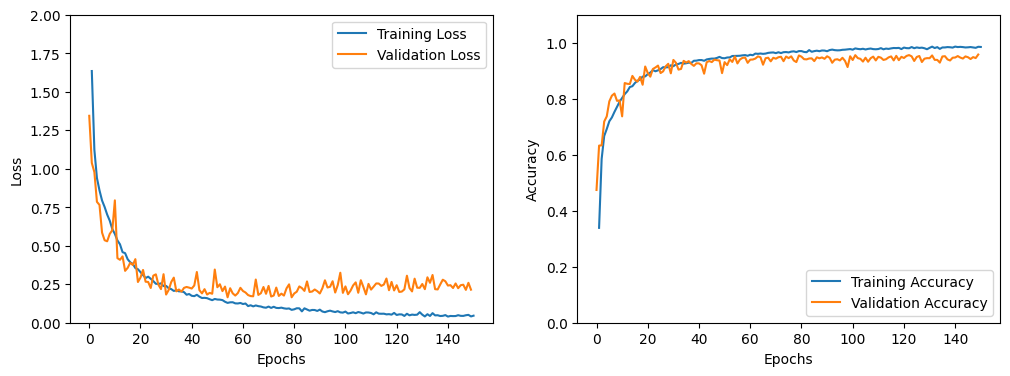

In [41]:
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

### Evaluation

In [42]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 150) - Validation Loss: 0.221, Validation Accuracy: 0.956


In [43]:

start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.955
Test Time: 20.08 seconds ---> 0.33 minutes


### Class Accuracy

In [44]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
           
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []
y_score = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_score.extend(outputs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, total_class)
for i in range(total_class):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       450
           1       0.98      0.99      0.99       450
           2       0.93      0.92      0.93       450
           3       0.95      0.97      0.96       375
           4       0.98      0.96      0.97       375
           5       0.91      0.95      0.93       300
           6       0.90      0.90      0.90       375
           7       0.96      0.99      0.98       450
           8       0.98      0.94      0.96       375
           9       0.99      0.99      0.99       450

    accuracy                           0.96      4050
   macro avg       0.95      0.95      0.95      4050
weighted avg       0.96      0.96      0.96      4050

Class 0 Accuracy: 0.924
Class 1 Accuracy: 0.987
Class 2 Accuracy: 0.918
Class 3 Accuracy: 0.976
Class 4 Accuracy: 0.957
Class 5 Accuracy: 0.960
Class 6 Accuracy: 0.923
Class 7 Accuracy: 0.991
Class 8 Accuracy: 0.939
Cl

### Confusion Matrix

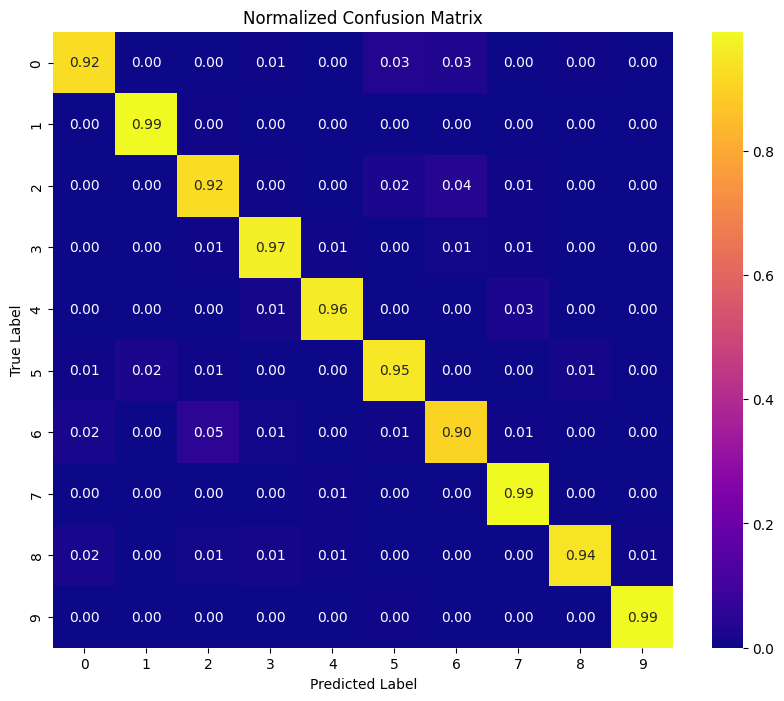

In [45]:
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='plasma', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()


### AUC ROC Curve

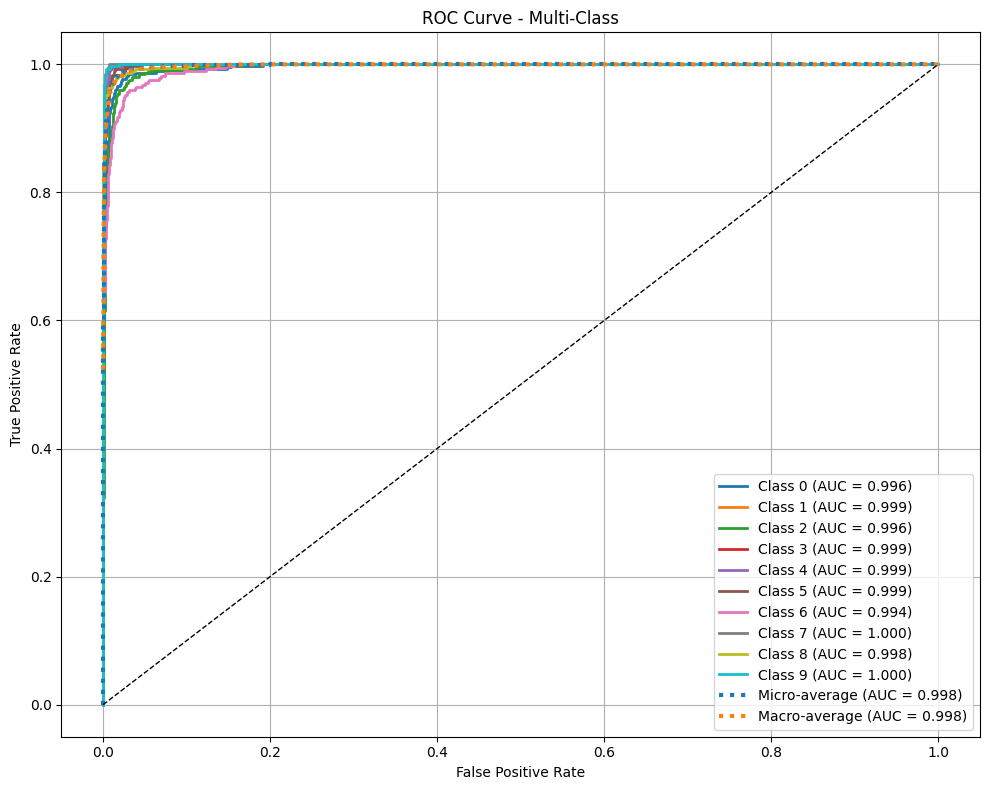

In [46]:
# Binarize the true labels
classes_list = sorted(list(set(y_true)))
y_true_bin = label_binarize(y_true, classes=classes_list)

fpr, tpr, roc_auc = {}, {}, {}

# Per-class ROC & AUC
for i in range(total_class):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(total_class)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(total_class):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= total_class
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# ----- Plot ROC curves -----
plt.figure(figsize=(10, 8))

# Per-class curves
for i in range(total_class):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f"Class {classes_list[i]} (AUC = {roc_auc[i]:.3f})")

# Micro and Macro curves
plt.plot(fpr["micro"], tpr["micro"], linestyle=':', linewidth=3,
         label=f"Micro-average (AUC = {roc_auc['micro']:.3f})")
plt.plot(fpr["macro"], tpr["macro"], linestyle=':', linewidth=3,
         label=f"Macro-average (AUC = {roc_auc['macro']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multi-Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()